## Import

In [417]:
import numpy as np 
import pandas as pd
import sqlite3
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.model_selection import train_test_split,learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import  precision_score, recall_score, f1_score,accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from scipy.stats import expon, reciprocal
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from imblearn.pipeline import Pipeline as ImbPipeline


In [2]:

def plot_learning_curves(model, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'):
    """
    Plots the learning curve for a given model.
    
    Parameters:
    - model: sklearn model
    - X: feature matrix
    - y: target vector
    - cv: cross-validation splitting strategy
    - train_sizes: array, list of train sizes to use
    - scoring: scoring strategy
    
    Returns:
    - None, but plots the learning curve
    """
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )

    # To calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # To alculate mean and standard deviation for test set scores
    validation_mean = np.mean(validation_scores, axis=1)
    validation_std = np.std(validation_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)

    plt.plot(train_sizes, validation_mean, label='Validation score', color='green', marker='o')
    plt.fill_between(train_sizes, validation_mean - validation_std, validation_mean + validation_std, color='green', alpha=0.15)

    plt.title('Learning Curve')
    plt.xlabel('Training Data Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()


## Dataset

In [2]:
path = "/Users/mac1/Downloads/data-society-european-soccer-data/original/soccer/database.sqlite"
#database = path + 'database.sqlite'
connection = sqlite3.connect(path)

In [3]:
# SQL query to select relevant features for match prediction, without the LIMIT clause
query = """
SELECT 
    m.id AS match_id,
    m.date AS match_date,
    m.season,
    ht.team_long_name AS home_team,
    at.team_long_name AS away_team,
    m.home_team_goal,
    m.away_team_goal,
    (SELECT AVG(overall_rating) FROM Player_Attributes 
      WHERE player_api_id IN 
        (m.home_player_1, m.home_player_2, m.home_player_3, m.home_player_4, m.home_player_5, 
         m.home_player_6, m.home_player_7, m.home_player_8, m.home_player_9, m.home_player_10, m.home_player_11)) 
         AS avg_home_player_rating,
    (SELECT AVG(overall_rating) FROM Player_Attributes 
      WHERE player_api_id IN 
        (m.away_player_1, m.away_player_2, m.away_player_3, m.away_player_4, m.away_player_5, 
         m.away_player_6, m.away_player_7, m.away_player_8, m.away_player_9, m.away_player_10, m.away_player_11)) 
         AS avg_away_player_rating,
    hta.buildUpPlaySpeed AS home_buildUpPlaySpeed,
    ata.buildUpPlaySpeed AS away_buildUpPlaySpeed,
    hta.defenceAggression AS home_defenceAggression,
    ata.defenceAggression AS away_defenceAggression,
    hta.defencePressure AS home_defencePressure,
    ata.defencePressure AS away_defencePressure
FROM Match m
JOIN League l ON m.league_id = l.id
JOIN Country c ON l.country_id = c.id
JOIN Team ht ON m.home_team_api_id = ht.team_api_id
JOIN Team at ON m.away_team_api_id = at.team_api_id
LEFT JOIN Team_Attributes hta ON ht.team_api_id = hta.team_api_id AND hta.date = 
    (SELECT MAX(date) FROM Team_Attributes hta2 WHERE hta.team_api_id = hta2.team_api_id AND hta2.date <= m.date)
LEFT JOIN Team_Attributes ata ON at.team_api_id = ata.team_api_id AND ata.date = 
    (SELECT MAX(date) FROM Team_Attributes ata2 WHERE ata.team_api_id = ata2.team_api_id AND ata2.date <= m.date)
WHERE c.name = 'England'
GROUP BY m.id
ORDER BY m.date DESC;

"""

In [ ]:
# To execute the query and load the data into a DataFrame
df = pd.read_sql_query(query, connection)

# To save the DataFrame to a CSV file
csv_file_path = '/Users/mac1/Downloads/untitled folder 2/match_data3.csv'
df.to_csv(csv_file_path, index=False)

print(f"Data saved to {csv_file_path}")

In [3]:
df = pd.read_csv('match_data3.csv')

In [4]:
df.head()

,match_id,match_date,season,home_team,away_team,home_team_goal,away_team_goal,avg_home_player_rating,avg_away_player_rating,home_buildUpPlaySpeed,away_buildUpPlaySpeed,home_defenceAggression,away_defenceAggression,home_defencePressure,away_defencePressure
0,4702,2016-05-17 00:00:00,2015/2016,Manchester United,Bournemouth,3,1,77.607143,65.851145,38.0,47.0,53.0,50.0,54.0,48.0
1,4699,2016-05-15 00:00:00,2015/2016,Arsenal,Aston Villa,4,0,78.088496,70.899160,59.0,63.0,44.0,44.0,51.0,35.0
2,4700,2016-05-15 00:00:00,2015/2016,Chelsea,Leicester City,1,1,78.630662,70.750000,67.0,63.0,41.0,65.0,39.0,58.0
3,4701,2016-05-15 00:00:00,2015/2016,Everton,Norwich City,3,0,75.987179,71.367347,43.0,45.0,58.0,39.0,52.0,38.0
4,4703,2016-05-15 00:00:00,2015/2016,Newcastle United,Tottenham Hotspur,5,1,71.278746,75.033898,58.0,47.0,39.0,54.0,41.0,63.0


## Feature Engineering

In [5]:
def calculate_form(df, team, num_matches):
    """
    Calculate the form of a given team over the last 'num_matches'.
    Form metrics can include win rate, average goals scored, and average goals conceded.
    """
    # Filter matches involving the team
    team_matches = df[(df['home_team'] == team) | (df['away_team'] == team)]
    
    # Calculate win rate, average goals scored/conceded in the last 'num_matches'
    recent_matches = team_matches.iloc[-num_matches:]
    wins = recent_matches.apply(lambda row: 1 if ((row['home_team'] == team and row['home_team_goal'] > row['away_team_goal']) or
                                                   (row['away_team'] == team and row['away_team_goal'] > row['home_team_goal'])) else 0, axis=1).sum()
    goals_scored = recent_matches.apply(lambda row: row['home_team_goal'] if row['home_team'] == team else row['away_team_goal'], axis=1).sum()
    goals_conceded = recent_matches.apply(lambda row: row['away_team_goal'] if row['home_team'] == team else row['home_team_goal'], axis=1).sum()
    
    win_rate = wins / num_matches
    avg_goals_scored = goals_scored / num_matches
    avg_goals_conceded = goals_conceded / num_matches
    
    return win_rate, avg_goals_scored, avg_goals_conceded


In [6]:
#  Adding form over the last 5 matches to the dataset
for index, row in df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Ensure there are enough past matches to calculate form
    if index >= 5:
        home_win_rate, home_avg_goals_scored, home_avg_goals_conceded = calculate_form(df.iloc[:index], home_team, 5)
        away_win_rate, away_avg_goals_scored, away_avg_goals_conceded = calculate_form(df.iloc[:index], away_team, 5)
        
        # Add calculated form metrics as new columns in your DataFrame (if not already added)
        df.at[index, 'home_win_rate_5'] = home_win_rate
        df.at[index, 'away_win_rate_5'] = away_win_rate
        df.at[index, 'home_avg_goals_scored_5'] = home_avg_goals_scored
        df.at[index, 'away_avg_goals_scored_5'] = away_avg_goals_scored
        df.at[index, 'home_avg_goals_conceded_5'] = home_avg_goals_conceded
        df.at[index, 'away_avg_goals_conceded_5'] = away_avg_goals_conceded



In [8]:
df

,match_id,match_date,season,home_team,away_team,home_team_goal,away_team_goal,avg_home_player_rating,avg_away_player_rating,home_buildUpPlaySpeed,...,home_defenceAggression,away_defenceAggression,home_defencePressure,away_defencePressure,home_win_rate_5,away_win_rate_5,home_avg_goals_scored_5,away_avg_goals_scored_5,home_avg_goals_conceded_5,away_avg_goals_conceded_5
0,4702,2016-05-17 00:00:00,2015/2016,Manchester United,Bournemouth,3,1,77.607143,65.851145,38.0,...,53.0,50.0,54.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN
1,4699,2016-05-15 00:00:00,2015/2016,Arsenal,Aston Villa,4,0,78.088496,70.899160,59.0,...,44.0,44.0,51.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN
2,4700,2016-05-15 00:00:00,2015/2016,Chelsea,Leicester City,1,1,78.630662,70.750000,67.0,...,41.0,65.0,39.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4701,2016-05-15 00:00:00,2015/2016,Everton,Norwich City,3,0,75.987179,71.367347,43.0,...,58.0,39.0,52.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN
4,4703,2016-05-15 00:00:00,2015/2016,Newcastle United,Tottenham Hotspur,5,1,71.278746,75.033898,58.0,...,39.0,54.0,41.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,1732,2008-08-16 00:00:00,2008/2009,West Ham United,Wigan Athletic,2,1,75.417722,73.039648,NaN,...,NaN,NaN,NaN,NaN,0.6,0.4,2.2,1.6,1.8,0.6
3036,1734,2008-08-16 00:00:00,2008/2009,Everton,Blackburn Rovers,2,3,78.427984,73.898058,NaN,...,NaN,NaN,NaN,NaN,0.4,0.4,1.4,1.0,2.0,2.0
3037,1735,2008-08-16 00:00:00,2008/2009,Middlesbrough,Tottenham Hotspur,2,1,72.429864,77.802326,NaN,...,NaN,NaN,NaN,NaN,0.2,0.0,0.8,0.6,1.6,1.4
3038,1736,2008-08-16 00:00:00,2008/2009,Bolton Wanderers,Stoke City,3,1,73.025210,69.742857,NaN,...,NaN,NaN,NaN,NaN,0.0,0.2,0.4,1.2,1.6,1.8


In [9]:
# interaction feature
df['home_goal_count_x_buildUpPlaySpeed'] = df['home_team_goal'] * df['home_buildUpPlaySpeed']

In [10]:
# interaction feature
df['away_goal_count_x_buildUpPlaySpeed'] = df['away_team_goal'] * df['away_buildUpPlaySpeed']

In [11]:
df

,match_id,match_date,season,home_team,away_team,home_team_goal,away_team_goal,avg_home_player_rating,avg_away_player_rating,home_buildUpPlaySpeed,...,home_defencePressure,away_defencePressure,home_win_rate_5,away_win_rate_5,home_avg_goals_scored_5,away_avg_goals_scored_5,home_avg_goals_conceded_5,away_avg_goals_conceded_5,home_goal_count_x_buildUpPlaySpeed,away_goal_count_x_buildUpPlaySpeed
0,4702,2016-05-17 00:00:00,2015/2016,Manchester United,Bournemouth,3,1,77.607143,65.851145,38.0,...,54.0,48.0,NaN,NaN,NaN,NaN,NaN,NaN,114.0,47.0
1,4699,2016-05-15 00:00:00,2015/2016,Arsenal,Aston Villa,4,0,78.088496,70.899160,59.0,...,51.0,35.0,NaN,NaN,NaN,NaN,NaN,NaN,236.0,0.0
2,4700,2016-05-15 00:00:00,2015/2016,Chelsea,Leicester City,1,1,78.630662,70.750000,67.0,...,39.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN,67.0,63.0
3,4701,2016-05-15 00:00:00,2015/2016,Everton,Norwich City,3,0,75.987179,71.367347,43.0,...,52.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,129.0,0.0
4,4703,2016-05-15 00:00:00,2015/2016,Newcastle United,Tottenham Hotspur,5,1,71.278746,75.033898,58.0,...,41.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN,290.0,47.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,1732,2008-08-16 00:00:00,2008/2009,West Ham United,Wigan Athletic,2,1,75.417722,73.039648,NaN,...,NaN,NaN,0.6,0.4,2.2,1.6,1.8,0.6,NaN,NaN
3036,1734,2008-08-16 00:00:00,2008/2009,Everton,Blackburn Rovers,2,3,78.427984,73.898058,NaN,...,NaN,NaN,0.4,0.4,1.4,1.0,2.0,2.0,NaN,NaN
3037,1735,2008-08-16 00:00:00,2008/2009,Middlesbrough,Tottenham Hotspur,2,1,72.429864,77.802326,NaN,...,NaN,NaN,0.2,0.0,0.8,0.6,1.6,1.4,NaN,NaN
3038,1736,2008-08-16 00:00:00,2008/2009,Bolton Wanderers,Stoke City,3,1,73.025210,69.742857,NaN,...,NaN,NaN,0.0,0.2,0.4,1.2,1.6,1.8,NaN,NaN


In [12]:
# Calculating difference in ratings
df['rating_difference'] = df['avg_home_player_rating'] - df['avg_away_player_rating']

# Calculating ratio of build-up play speed
df['buildUpPlaySpeed_ratio'] = df['home_buildUpPlaySpeed'] / df['away_buildUpPlaySpeed']

df

,match_id,match_date,season,home_team,away_team,home_team_goal,away_team_goal,avg_home_player_rating,avg_away_player_rating,home_buildUpPlaySpeed,...,home_win_rate_5,away_win_rate_5,home_avg_goals_scored_5,away_avg_goals_scored_5,home_avg_goals_conceded_5,away_avg_goals_conceded_5,home_goal_count_x_buildUpPlaySpeed,away_goal_count_x_buildUpPlaySpeed,rating_difference,buildUpPlaySpeed_ratio
0,4702,2016-05-17 00:00:00,2015/2016,Manchester United,Bournemouth,3,1,77.607143,65.851145,38.0,...,NaN,NaN,NaN,NaN,NaN,NaN,114.0,47.0,11.755998,0.808511
1,4699,2016-05-15 00:00:00,2015/2016,Arsenal,Aston Villa,4,0,78.088496,70.899160,59.0,...,NaN,NaN,NaN,NaN,NaN,NaN,236.0,0.0,7.189336,0.936508
2,4700,2016-05-15 00:00:00,2015/2016,Chelsea,Leicester City,1,1,78.630662,70.750000,67.0,...,NaN,NaN,NaN,NaN,NaN,NaN,67.0,63.0,7.880662,1.063492
3,4701,2016-05-15 00:00:00,2015/2016,Everton,Norwich City,3,0,75.987179,71.367347,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,129.0,0.0,4.619833,0.955556
4,4703,2016-05-15 00:00:00,2015/2016,Newcastle United,Tottenham Hotspur,5,1,71.278746,75.033898,58.0,...,NaN,NaN,NaN,NaN,NaN,NaN,290.0,47.0,-3.755153,1.234043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,1732,2008-08-16 00:00:00,2008/2009,West Ham United,Wigan Athletic,2,1,75.417722,73.039648,NaN,...,0.6,0.4,2.2,1.6,1.8,0.6,NaN,NaN,2.378074,NaN
3036,1734,2008-08-16 00:00:00,2008/2009,Everton,Blackburn Rovers,2,3,78.427984,73.898058,NaN,...,0.4,0.4,1.4,1.0,2.0,2.0,NaN,NaN,4.529925,NaN
3037,1735,2008-08-16 00:00:00,2008/2009,Middlesbrough,Tottenham Hotspur,2,1,72.429864,77.802326,NaN,...,0.2,0.0,0.8,0.6,1.6,1.4,NaN,NaN,-5.372461,NaN
3038,1736,2008-08-16 00:00:00,2008/2009,Bolton Wanderers,Stoke City,3,1,73.025210,69.742857,NaN,...,0.0,0.2,0.4,1.2,1.6,1.8,NaN,NaN,3.282353,NaN


In [13]:
df['output'] = df.apply(lambda row: 'H' if row['home_team_goal'] > row['away_team_goal'] 
                        else ('D' if row['home_team_goal'] == row['away_team_goal'] else 'A'), axis=1)


In [14]:
df

,match_id,match_date,season,home_team,away_team,home_team_goal,away_team_goal,avg_home_player_rating,avg_away_player_rating,home_buildUpPlaySpeed,...,away_win_rate_5,home_avg_goals_scored_5,away_avg_goals_scored_5,home_avg_goals_conceded_5,away_avg_goals_conceded_5,home_goal_count_x_buildUpPlaySpeed,away_goal_count_x_buildUpPlaySpeed,rating_difference,buildUpPlaySpeed_ratio,output
0,4702,2016-05-17 00:00:00,2015/2016,Manchester United,Bournemouth,3,1,77.607143,65.851145,38.0,...,NaN,NaN,NaN,NaN,NaN,114.0,47.0,11.755998,0.808511,H
1,4699,2016-05-15 00:00:00,2015/2016,Arsenal,Aston Villa,4,0,78.088496,70.899160,59.0,...,NaN,NaN,NaN,NaN,NaN,236.0,0.0,7.189336,0.936508,H
2,4700,2016-05-15 00:00:00,2015/2016,Chelsea,Leicester City,1,1,78.630662,70.750000,67.0,...,NaN,NaN,NaN,NaN,NaN,67.0,63.0,7.880662,1.063492,D
3,4701,2016-05-15 00:00:00,2015/2016,Everton,Norwich City,3,0,75.987179,71.367347,43.0,...,NaN,NaN,NaN,NaN,NaN,129.0,0.0,4.619833,0.955556,H
4,4703,2016-05-15 00:00:00,2015/2016,Newcastle United,Tottenham Hotspur,5,1,71.278746,75.033898,58.0,...,NaN,NaN,NaN,NaN,NaN,290.0,47.0,-3.755153,1.234043,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,1732,2008-08-16 00:00:00,2008/2009,West Ham United,Wigan Athletic,2,1,75.417722,73.039648,NaN,...,0.4,2.2,1.6,1.8,0.6,NaN,NaN,2.378074,NaN,H
3036,1734,2008-08-16 00:00:00,2008/2009,Everton,Blackburn Rovers,2,3,78.427984,73.898058,NaN,...,0.4,1.4,1.0,2.0,2.0,NaN,NaN,4.529925,NaN,A
3037,1735,2008-08-16 00:00:00,2008/2009,Middlesbrough,Tottenham Hotspur,2,1,72.429864,77.802326,NaN,...,0.0,0.8,0.6,1.6,1.4,NaN,NaN,-5.372461,NaN,H
3038,1736,2008-08-16 00:00:00,2008/2009,Bolton Wanderers,Stoke City,3,1,73.025210,69.742857,NaN,...,0.2,0.4,1.2,1.6,1.8,NaN,NaN,3.282353,NaN,H


In [15]:
df = df.drop(['match_id', 'match_date', 'season', 'home_team_goal', 'away_team_goal'], axis=1)

In [16]:
df.tail()

,home_team,away_team,avg_home_player_rating,avg_away_player_rating,home_buildUpPlaySpeed,away_buildUpPlaySpeed,home_defenceAggression,away_defenceAggression,home_defencePressure,away_defencePressure,...,away_win_rate_5,home_avg_goals_scored_5,away_avg_goals_scored_5,home_avg_goals_conceded_5,away_avg_goals_conceded_5,home_goal_count_x_buildUpPlaySpeed,away_goal_count_x_buildUpPlaySpeed,rating_difference,buildUpPlaySpeed_ratio,output
3035,West Ham United,Wigan Athletic,75.417722,73.039648,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4,2.2,1.6,1.8,0.6,NaN,NaN,2.378074,NaN,H
3036,Everton,Blackburn Rovers,78.427984,73.898058,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4,1.4,1.0,2.0,2.0,NaN,NaN,4.529925,NaN,A
3037,Middlesbrough,Tottenham Hotspur,72.429864,77.802326,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.8,0.6,1.6,1.4,NaN,NaN,-5.372461,NaN,H
3038,Bolton Wanderers,Stoke City,73.025210,69.742857,NaN,NaN,NaN,NaN,NaN,NaN,...,0.2,0.4,1.2,1.6,1.8,NaN,NaN,3.282353,NaN,H
3039,Hull City,Fulham,69.246073,74.401786,NaN,NaN,NaN,NaN,NaN,NaN,...,0.4,1.4,0.8,2.0,1.0,NaN,NaN,-5.155712,NaN,H


In [17]:
df = pd.DataFrame(df)

In [18]:

%matplotlib inline

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   home_team                           3040 non-null   object 
 1   away_team                           3040 non-null   object 
 2   avg_home_player_rating              3040 non-null   float64
 3   avg_away_player_rating              3040 non-null   float64
 4   home_buildUpPlaySpeed               2396 non-null   float64
 5   away_buildUpPlaySpeed               2396 non-null   float64
 6   home_defenceAggression              2396 non-null   float64
 7   away_defenceAggression              2396 non-null   float64
 8   home_defencePressure                2396 non-null   float64
 9   away_defencePressure                2396 non-null   float64
 10  home_win_rate_5                     3035 non-null   float64
 11  away_win_rate_5                     3035 no

## Test/Train Split

In [435]:
X = df[['home_team', 'away_team', 'avg_home_player_rating','avg_away_player_rating', 'home_buildUpPlaySpeed', 'away_buildUpPlaySpeed', 'home_win_rate_5', 'away_win_rate_5', 'home_avg_goals_scored_5', 'away_avg_goals_scored_5', 'home_avg_goals_conceded_5', 'away_avg_goals_conceded_5','home_goal_count_x_buildUpPlaySpeed','away_goal_count_x_buildUpPlaySpeed', 'rating_difference', 'buildUpPlaySpeed_ratio', 'home_defenceAggression','away_defenceAggression','home_defencePressure', 'away_defencePressure']]

Y = df['output']

In [436]:
# encode strings to integer
Ly = LabelEncoder().fit(Y)
y = Ly.transform(Y).astype(int)

In [437]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


print('Number of training examples',len(X_train))
print('Number of validation examples',len(X_test))

Number of training examples 2432
Number of validation examples 608


## Dataset Preprocessing

In [64]:
# Define the custom transformer for casting to float32
class Float32Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.astype(np.float32)
    
# Numeric features to be scaled
numeric_features = ['avg_home_player_rating',
       'avg_away_player_rating', 'home_buildUpPlaySpeed',
       'away_buildUpPlaySpeed', 'home_defenceAggression',
       'away_defenceAggression', 'home_defencePressure',
       'away_defencePressure', 'home_win_rate_5', 'away_win_rate_5',
       'home_avg_goals_scored_5', 'away_avg_goals_scored_5',
       'home_avg_goals_conceded_5', 'away_avg_goals_conceded_5',
       'home_goal_count_x_buildUpPlaySpeed',
       'away_goal_count_x_buildUpPlaySpeed', 'rating_difference',
       'buildUpPlaySpeed_ratio']  
# Categorical features to be one-hot encoded
categorical_features = ['home_team', 'away_team'] 

# preprocessing pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('to_float32', Float32Transformer())])

# preprocessing pipeline for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', dtype=np.float32))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



In [66]:
class_counts = df['output'].value_counts()
print(class_counts)

output
H    1390
A     867
D     783
Name: count, dtype: int64


In [67]:
class_distribution = df['output'].value_counts(normalize=True) * 100
print(class_distribution)


output
H    45.723684
A    28.519737
D    25.756579
Name: proportion, dtype: float64


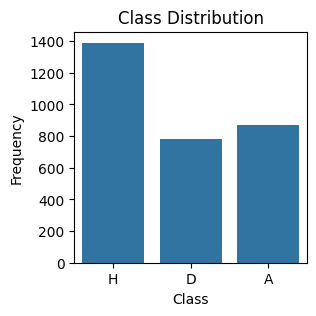

In [68]:
plt.figure(figsize=(3, 3))
sns.countplot(x='output', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Random Forest

In [39]:

param_distributions = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [ None, 100, 200],
    'classifier__min_samples_split': [20, 50, 80],
    'classifier__min_samples_leaf': [20, 60, 80],
    'classifier__max_features': ['sqrt', 'log2', 0.5],
    'classifier__class_weight': ['balanced_subsample', 'balanced'],
    'classifier__bootstrap': [True, False]
}


In [41]:

# Create a SMOTE object to oversample the minority class
smote = SMOTE(random_state=42)

In [42]:
# Create the complete pipeline
pipeline_RFE =  ImblearnPipeline([('preprocessor', preprocessor),
                              ('smote', smote),
                           ('classifier', RandomForestClassifier(random_state=42))])


In [43]:
# Configure the randomized search
random_search = RandomizedSearchCV(pipeline, param_distributions=param_distributions, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

# Fit the randomized search object to the training data
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=100, classifier__max_features=sqrt, classifier__min_samples_leaf=20, classifier__min_samples_split=80, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=100, classifier__max_features=sqrt, classifier__min_samples_leaf=20, classifier__min_samples_split=80, classifier__n_estimators=100; total time=   1.6s
[CV] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=100, classifier__max_features=sqrt, classifier__min_samples_leaf=20, classifier__min_samples_split=80, classifier__n_estimators=100; total time=   1.5s
[CV] END classifier__bootstrap=True, classifier__class_weight=balanced, classifier__max_depth=100, classifier__max_features=sqrt, classifier__min_samples_leaf=20, classifier__min_samples_split=80, clas

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('to_float32',
                                                                                                Float32Transformer())]),
                                                                               ['avg_home_player_rating',
                                                                                'avg_away_player_rating',
                                                                                'home_buildUpPlaySpeed',
                                                                                'away_buildUpPlaySpeed',
                                                                                'home_defenceAggres...
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__class_weight': ['balanced_subsample',
                                                                     'balanced'],
                                        'classifier__max_depth': [None, 100,
                                                                  200],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     0.5],
                                        'classifier__min_samples_leaf': [20, 60,
                                                                         80],
                                        'classifier__min_samples_split': [20,
                                                                          50,
                                                                          80],
                                        'classifier__n_estimators': [100, 200]},
                   random_state=42, verbose=2)

In [44]:
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

# Evaluate on the test set
test_score = random_search.score(X_test, y_test)
print("Test set score: ", test_score)
# Evaluate on the train set
train_score = random_search.score(X_train, y_train)
print("Train set score: ", train_score)


Best parameters found:  {'classifier__n_estimators': 200, 'classifier__min_samples_split': 80, 'classifier__min_samples_leaf': 20, 'classifier__max_features': 0.5, 'classifier__max_depth': 200, 'classifier__class_weight': 'balanced', 'classifier__bootstrap': False}
Best cross-validation score:  0.843334938863116
Test set score:  0.8552631578947368
Train set score:  0.8951480263157895


In [45]:

y_pred = random_search.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy:{accuracy}")


Precision: 0.8594247766256548
Recall: 0.8552631578947368
F1 Score: 0.8564794521233697
Accuracy:0.8552631578947368


## Use all data with CV

In [32]:
# Incorporating SMOTE to handle class imbalance
smote = SMOTE(random_state=42)

classifier = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')
# Define pipeline 
pipeline = make_pipeline_imb(
    preprocessor,
    smote,
    classifier
)

# Define scoring metrics
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, average='weighted'),  # Adjust according to your needs
           'recall': make_scorer(recall_score, average='weighted'),  # Adjust according to your needs
           'f1_score': make_scorer(f1_score, average='weighted')} 

# Use StratifiedKFold for cross-validation to maintain the percentage of samples for each class
cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)

# Perform cross-validation

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)  # cv=5 specifies a 5-fold cross-validation

#print("Accuracy scores for each fold:", scores)
#print("Mean cross-validation accuracy:", scores.mean())


In [33]:
# Print scores for each metric
for metric in scoring:
    metric_scores = scores[f'test_{metric}']
    print(f"{metric.capitalize()} scores for each fold:", metric_scores)
    print(f"Mean {metric.capitalize()}:", metric_scores.mean())

Accuracy scores for each fold: [0.78500986 0.82248521 0.81854043 0.78303748 0.82213439 0.82608696]
Mean Accuracy: 0.8095490536962108
Precision scores for each fold: [0.78587442 0.81996826 0.81527497 0.77925138 0.82241683 0.82410654]
Mean Precision: 0.8078154007414079
Recall scores for each fold: [0.78500986 0.82248521 0.81854043 0.78303748 0.82213439 0.82608696]
Mean Recall: 0.8095490536962108
F1_score scores for each fold: [0.78464701 0.81965656 0.81445972 0.7805142  0.82207285 0.82450086]
Mean F1_score: 0.8076418664467769


## Feature Selection

In [67]:
# parameter grid
param_grid = {'classifier__n_estimators': [100, 200],
              'classifier__max_depth': [None, 10, 20],
              'feature_elimination__n_features_to_select': [5, 10, 15]}

# GridSearchCV object
grid_search = GridSearchCV(pipeline_RFE, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Best parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 100, 'feature_elimination__n_features_to_select': 10}
Best cross-validation score: 0.86


In [71]:
# best estimator from the grid search
best_model = grid_search.best_estimator_

# Predict on the validation set
y_pred_test = best_model.predict(X_test)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


Validation Accuracy: 0.8569078947368421
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       172
           1       0.80      0.73      0.77       150
           2       0.87      0.91      0.89       286

    accuracy                           0.86       608
   macro avg       0.85      0.84      0.84       608
weighted avg       0.86      0.86      0.86       608



In [72]:
importances = best_model.named_steps['classifier'].feature_importances_
selected_features = transformed_feature_names[best_model.named_steps['feature_elimination'].support_]

# Dictionary of features and their importance scores
feature_importance_dict = dict(zip(selected_features, importances))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
print("Sorted Feature Importances:", sorted_feature_importance)


Sorted Feature Importances: [('home_goal_count_x_buildUpPlaySpeed', 0.2989666966280148), ('away_goal_count_x_buildUpPlaySpeed', 0.29454061463065856), ('rating_difference', 0.0768690873066816), ('avg_home_player_rating', 0.060371512567891604), ('avg_away_player_rating', 0.060338540560018146), ('buildUpPlaySpeed_ratio', 0.05171330068819019), ('away_avg_goals_scored_5', 0.04126784827577079), ('home_avg_goals_conceded_5', 0.039913939097720674), ('home_avg_goals_scored_5', 0.038365337556582085), ('away_avg_goals_conceded_5', 0.03765312268847183)]


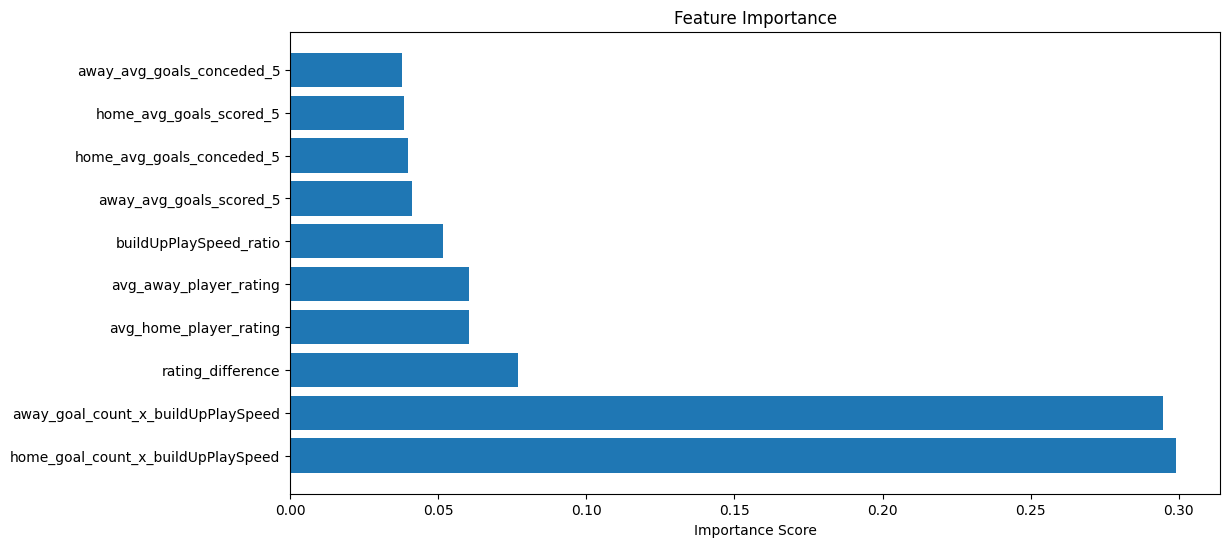

In [73]:


# Extracting names and importance scores
features, importance_scores = zip(*sorted_feature_importance)

plt.barh(features, importance_scores)
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()


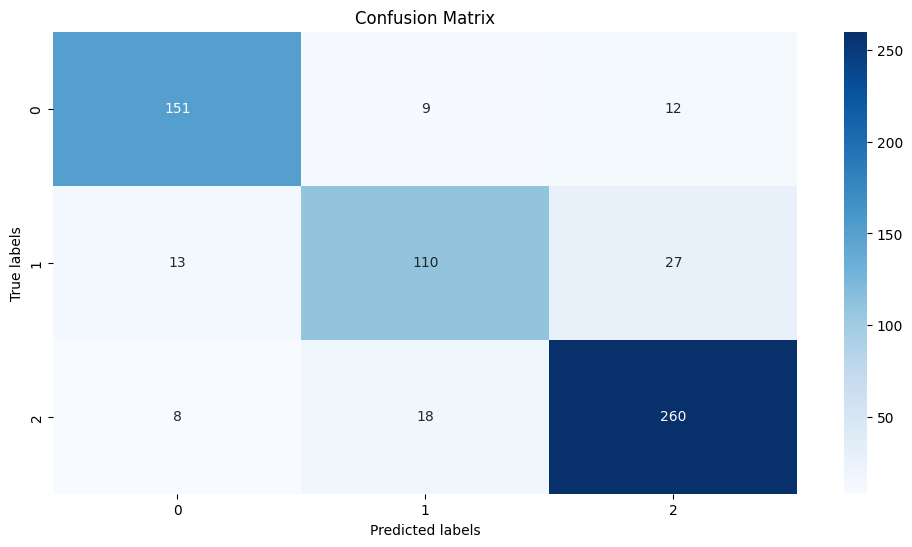

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       172
           1       0.80      0.73      0.77       150
           2       0.87      0.91      0.89       286

    accuracy                           0.86       608
   macro avg       0.85      0.84      0.84       608
weighted avg       0.86      0.86      0.86       608



In [99]:



# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, y_pred_test))


## SVM

In [52]:
pipeline_ = Pipeline([
    ('preprocessor', preprocessor),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('svm', SVC(random_state=42, class_weight='balanced'))
])

In [105]:
# parameter grid
param_distributions = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__degree': [2,3,4]
}


In [106]:
# RandomizedSearchCV
random_search_SVM = RandomizedSearchCV(pipeline_, param_distributions=param_distributions, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [107]:
# Fit RandomizedSearchCV
random_search_SVM.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END svm__C=100, svm__degree=4, svm__gamma=auto, svm__kernel=linear; total time=   5.2s
[CV] END svm__C=100, svm__degree=4, svm__gamma=auto, svm__kernel=linear; total time=   5.3s
[CV] END svm__C=100, svm__degree=4, svm__gamma=auto, svm__kernel=linear; total time=   5.3s
[CV] END svm__C=100, svm__degree=4, svm__gamma=10, svm__kernel=linear; total time=   5.3s
[CV] END svm__C=100, svm__degree=4, svm__gamma=auto, svm__kernel=linear; total time=   5.3s
[CV] END svm__C=100, svm__degree=4, svm__gamma=10, svm__kernel=linear; total time=   5.3s
[CV] END svm__C=100, svm__degree=4, svm__gamma=10, svm__kernel=linear; total time=   5.4s
[CV] END svm__C=100, svm__degree=4, svm__gamma=auto, svm__kernel=linear; total time=   5.4s
[CV] END svm__C=100, svm__degree=4, svm__gamma=10, svm__kernel=linear; total time=   3.6s
[CV] END svm__C=100, svm__degree=4, svm__gamma=10, svm__kernel=linear; total time=   3.6s
[CV] END svm__C=10, svm__degr

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler()),
                                                                                               ('to_float32',
                                                                                                Float32Transformer())]),
                                                                               ['avg_home_player_rating',
                                                                                'avg_away_player_rating',
                                                                                'home_buildUpPlaySpeed',
                                                                                'away_buildUpPlaySpeed',
                                                                                'home_defenceAggres...
                                                                                                OneHotEncoder(dtype=<class 'numpy.float32'>,
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['home_team',
                                                                                'away_team'])])),
                                             ('poly_features',
                                              PolynomialFeatures()),
                                             ('svm',
                                              SVC(class_weight='balanced',
                                                  random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'svm__C': [0.1, 1, 10, 100],
                                        'svm__degree': [2, 3, 4],
                                        'svm__gamma': ['scale', 'auto', 0.01,
                                                       0.1, 1, 10],
                                        'svm__kernel': ['linear', 'rbf',
                                                        'poly']},
                   random_state=42, verbose=2)

In [113]:
# Evaluate the best model found on the test set
print("Best parameters:", random_search_SVM.best_params_)
print("Best cross-validation score:", random_search_SVM.best_score_)
print("Test set score:", random_search_SVM.score(X_test, y_test))



Best parameters: {'svm__kernel': 'linear', 'svm__gamma': 10, 'svm__degree': 2, 'svm__C': 0.1}
Best cross-validation score: 0.8059134196939354
Test set score: 0.8223684210526315


In [109]:
y_pred_SVM = random_search_SVM.predict(X_test)

In [110]:
acc_SVM = accuracy_score(y_test, y_pred_SVM)

In [111]:

print ("The accuracy on validation dataset: \t", accuracy_score(y_test, y_pred_SVM))
print ("Precision on validation dataset: \t", precision_score(y_test, y_pred_SVM, average='weighted'))
print ("Recall on validation dataset : \t", recall_score(y_test, y_pred_SVM, average='weighted'))
print ("F1 score on validation dataset: \t", f1_score(y_test, y_pred_SVM, average='weighted'))


The accuracy on validation dataset: 	 0.8223684210526315
Precision on validation dataset: 	 0.8300304121468303
Recall on validation dataset : 	 0.8223684210526315
F1 score on validation dataset: 	 0.8248544575778283


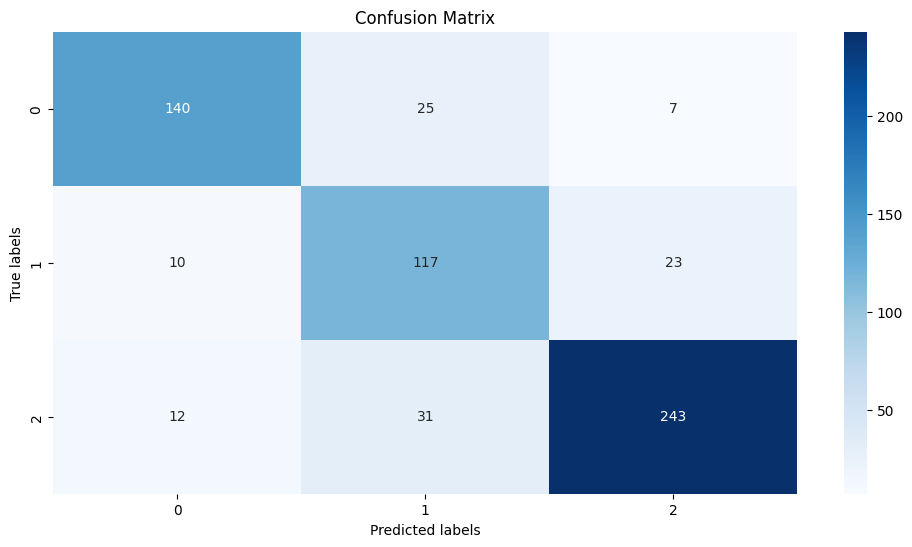

              precision    recall  f1-score   support

           0       0.86      0.81      0.84       172
           1       0.68      0.78      0.72       150
           2       0.89      0.85      0.87       286

    accuracy                           0.82       608
   macro avg       0.81      0.81      0.81       608
weighted avg       0.83      0.82      0.82       608



In [112]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_SVM)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, y_pred_SVM))


In [120]:
# pipeline with recursive feature elimination and classification
pipeline_SVM =  ImblearnPipeline([('preprocessor', preprocessor),
                               ('feature_elimination', RFE(estimator=SVC(kernel='linear'), n_features_to_select=10)),
                              ('smote', smote),
                           ('svc', SVC(C=0.1, kernel='linear'))])

# Fit the pipeline
pipeline_SVM.fit(X_train, y_train)

# transformed feature names
transformed_feature_names = get_feature_names(preprocessor)

# mask of selected features from RFE
selected_mask_SVM = pipeline_SVM.named_steps['feature_elimination'].support_
selected_features_SVM = transformed_feature_names[selected_mask]

print("Selected features:", selected_features_SVM)

Selected features: ['avg_home_player_rating' 'avg_away_player_rating'
 'home_avg_goals_scored_5' 'away_avg_goals_scored_5'
 'home_avg_goals_conceded_5' 'away_avg_goals_conceded_5'
 'home_goal_count_x_buildUpPlaySpeed' 'away_goal_count_x_buildUpPlaySpeed'
 'rating_difference' 'buildUpPlaySpeed_ratio']


In [119]:
# Predict on the validation set (assuming X_val is preprocessed accordingly)
y_pred_SVM_RFE = pipeline_SVM.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_SVM_RFE))
print(classification_report(y_test, y_pred_SVM_RFE))

Accuracy: 0.8009868421052632
              precision    recall  f1-score   support

           0       0.89      0.77      0.83       172
           1       0.57      0.91      0.70       150
           2       0.99      0.76      0.86       286

    accuracy                           0.80       608
   macro avg       0.82      0.81      0.80       608
weighted avg       0.86      0.80      0.81       608



In [123]:


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# parameter grid
param_grid_SVM = {
    'feature_elimination__n_features_to_select': [5, 10, 15, 20], 
    'svc__C': [0.1, 1, 10]}

# GridSearchCV object
grid_search_SVM = GridSearchCV(pipeline_SVM, param_grid_SVM, cv=cv, scoring='accuracy')
grid_search_SVM.fit(X_train, y_train)

# Best model
print("Best parameters:", grid_search_SVM.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search_SVM.best_score_))


Best parameters: {'feature_elimination__n_features_to_select': 20, 'svc__C': 1}
Best cross-validation score: 0.82


In [124]:
# best estimator from the grid search
best_model_ = grid_search_SVM.best_estimator_

# Predict on the validation set
y_pred_test_RF = best_model_.predict(X_test)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_test, y_pred_test_RF))
print(classification_report(y_test, y_pred_test_RF))


Validation Accuracy: 0.8223684210526315
              precision    recall  f1-score   support

           0       0.89      0.82      0.85       172
           1       0.61      0.86      0.71       150
           2       0.97      0.80      0.88       286

    accuracy                           0.82       608
   macro avg       0.82      0.83      0.82       608
weighted avg       0.86      0.82      0.83       608



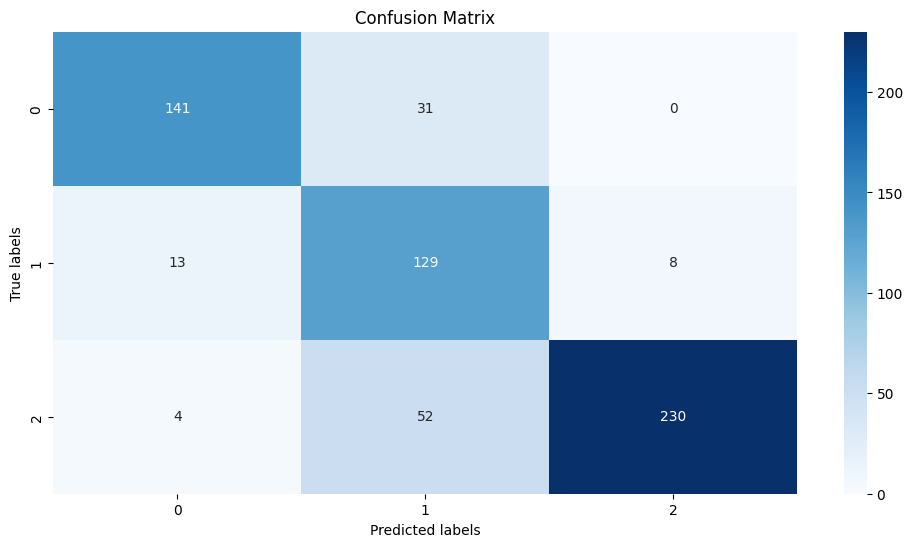

              precision    recall  f1-score   support

           0       0.89      0.82      0.85       172
           1       0.61      0.86      0.71       150
           2       0.97      0.80      0.88       286

    accuracy                           0.82       608
   macro avg       0.82      0.83      0.82       608
weighted avg       0.86      0.82      0.83       608



In [125]:



# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_RF)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, y_pred_test_RF))


## Bagging with Random Forest

In [127]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 100, 'feature_elimination__n_features_to_select': 10}


In [128]:
best_randomforest = RandomForestClassifier(
    n_estimators=100,
    max_depth=20
)

In [130]:
# Initialize the BaggingClassifier using the RandomForestClassifier instance
clf = BaggingClassifier(estimator=best_randomforest, n_estimators=100, random_state=30)

In [131]:

# Create a SMOTE object to oversample the minority class
smote = SMOTE(random_state=42)

In [154]:
pipeline_ =  ImblearnPipeline([('preprocessor', preprocessor),
                               ('feature_selection', RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=10)),
                              ('smote', smote),
                           ('bagging', clf)])

In [155]:


param_grid = {
    'bagging__estimator__max_depth': [3, 5, 10],  
    'bagging__n_estimators': [10, 50, 100]           
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline_, param_grid, cv=cv)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters: {'bagging__estimator__max_depth': 10, 'bagging__n_estimators': 10}
Best cross-validation score: 0.85


In [156]:
# best estimator from the grid search
best_model_BG = grid_search.best_estimator_

# Predict on the validation set
y_pred_test_BG = best_model_BG.predict(X_test)

# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_test, y_pred_test_BG))
print(classification_report(y_test, y_pred_test_BG))


Validation Accuracy: 0.8618421052631579
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       172
           1       0.73      0.81      0.77       150
           2       0.93      0.88      0.90       286

    accuracy                           0.86       608
   macro avg       0.85      0.86      0.85       608
weighted avg       0.87      0.86      0.86       608



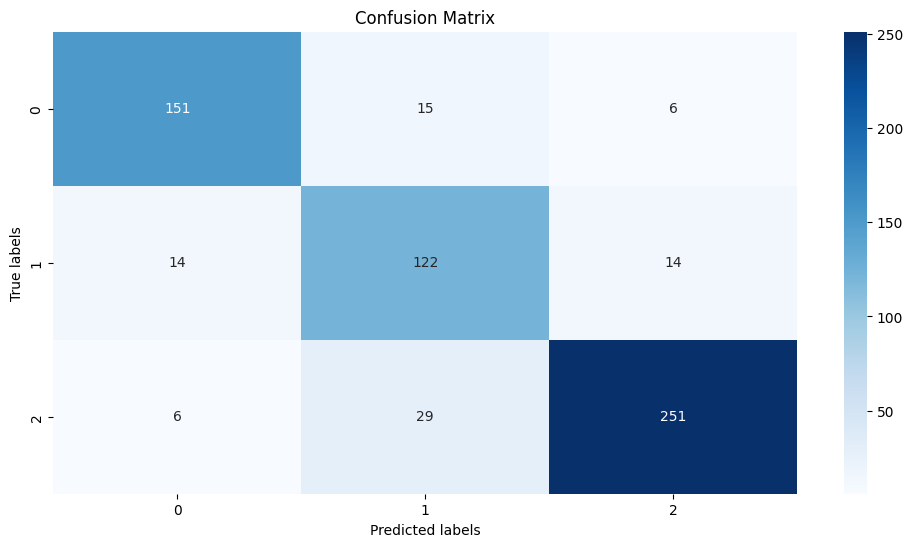

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       172
           1       0.73      0.81      0.77       150
           2       0.93      0.88      0.90       286

    accuracy                           0.86       608
   macro avg       0.85      0.86      0.85       608
weighted avg       0.87      0.86      0.86       608



In [157]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_BG)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, y_pred_test_BG))


## Gradient Boosting

In [158]:
# GradientBoostingClassifier
gradient_boosting_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# SMOTE object to oversample the minority class
smote = SMOTE(random_state=42)

# preprocessing and classification pipeline
pipeline_GB = ImblearnPipeline([('preprocessor', preprocessor),
                               ('feature_selection', RFE(estimator=RandomForestClassifier(n_estimators=100), n_features_to_select=10)),
                              ('smote', smote),
                            ('gb_RF', gradient_boosting_classifier)])
# Fit the model
pipeline_GB.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('to_float32',
                                                                   Float32Transformer())]),
                                                  ['avg_home_player_rating',
                                                   'avg_away_player_rating',
                                                   'home_buildUpPlaySpeed',
                                                   'away_buildUpPlaySpeed',
                                                   'home_defenceAggression',
                                                   'away_defenceAggression',
                                                   'ho...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(dtype=<class 'numpy.float32'>,
                                                                                 handle_unknown='ignore'))]),
                                                  ['home_team',
                                                   'away_team'])])),
                ('feature_selection',
                 RFE(estimator=RandomForestClassifier(),
                     n_features_to_select=10)),
                ('smote', SMOTE(random_state=42)),
                ('gb_RF', GradientBoostingClassifier(random_state=42))])

In [159]:
# Predict with the model
predictions = pipeline_GB.predict(X_test)

In [160]:
print(f"Accuracy: {accuracy_score(y_test,predictions)}")

Accuracy: 0.8651315789473685


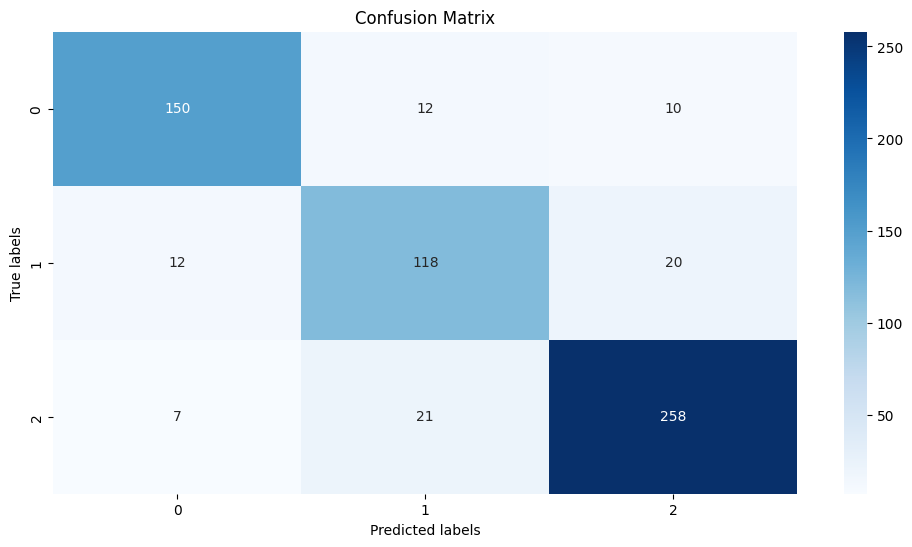

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       172
           1       0.78      0.79      0.78       150
           2       0.90      0.90      0.90       286

    accuracy                           0.87       608
   macro avg       0.85      0.85      0.85       608
weighted avg       0.87      0.87      0.87       608



In [161]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, predictions))


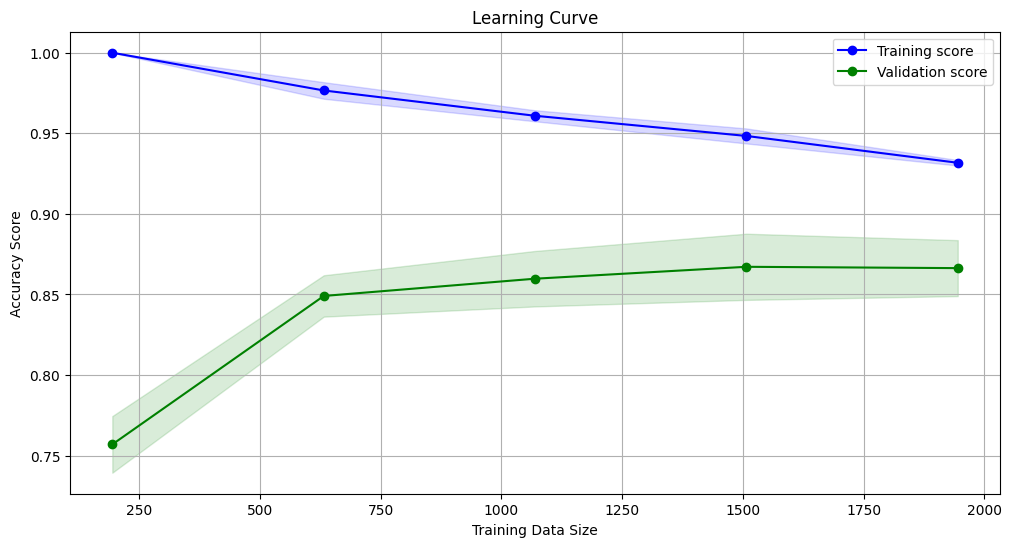

In [222]:
plot_learning_curves(pipeline_GB, X_train, y_train, cv=cv)

## Bagging with SVM

In [163]:
bagging_SV = BaggingClassifier(estimator=SVC(C=1), n_estimators=10, random_state=42)

In [171]:
#  pipeline
pipeline_SVM = ImblearnPipeline([('preprocessor', preprocessor),
                               ('feature_selection', RFE(estimator=SVC(kernel='linear'), n_features_to_select=10)),
                              ('smote', smote),
                            ('bagging_SVM', bagging_SV)]).fit(X_train, y_train)


In [172]:
predictions_SVM = pipeline_SVM.predict(X_test)

In [173]:
print(f"Accuracy: {accuracy_score(y_test, predictions_SVM)}")

Accuracy: 0.8240131578947368


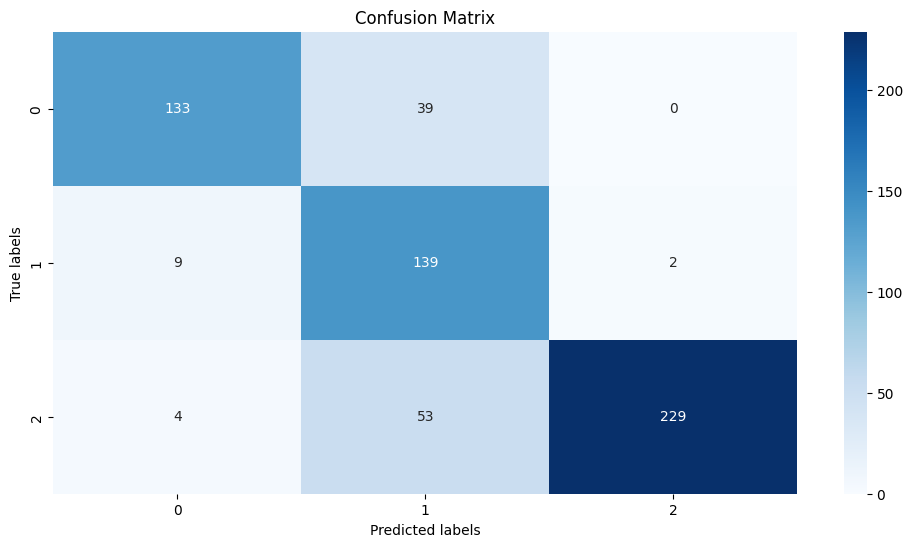

              precision    recall  f1-score   support

           0       0.91      0.77      0.84       172
           1       0.60      0.93      0.73       150
           2       0.99      0.80      0.89       286

    accuracy                           0.82       608
   macro avg       0.83      0.83      0.82       608
weighted avg       0.87      0.82      0.83       608



In [174]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, predictions_SVM)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, predictions_SVM))


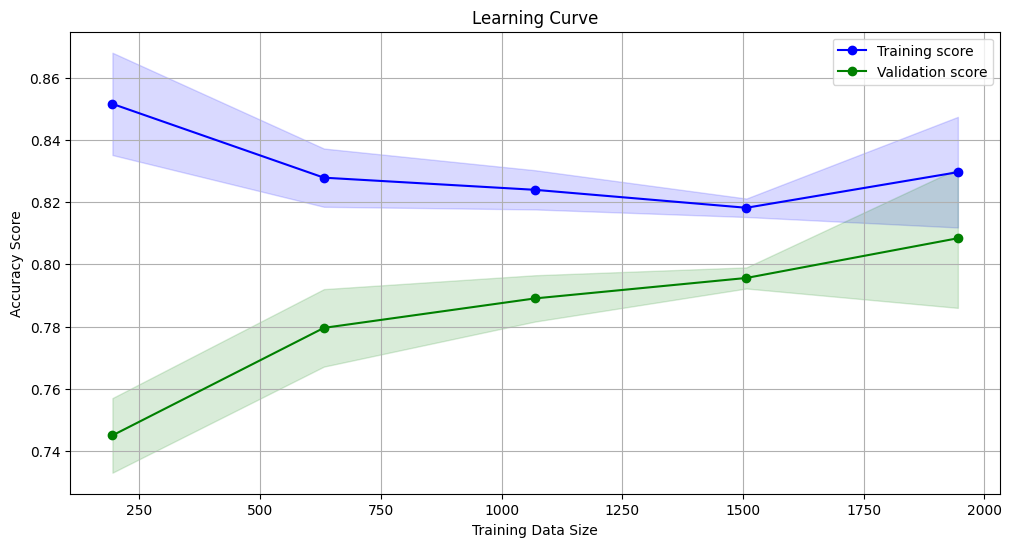

In [221]:
plot_learning_curves(pipeline_SVM, X_train, y_train, cv=cv)

## AdaBoost with SVM

In [382]:
ada_boost_clf = AdaBoostClassifier(estimator=SVC(), algorithm='SAMME', learning_rate=0.1, n_estimators=100, random_state=42)

In [389]:
pipeline_SVM_boosting = ImblearnPipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', RFE(estimator=SVC(kernel='linear'))),
    ('smote', smote),
    ('gb_SVM', ada_boost_clf)
])

In [390]:
param_grid = {
    'feature_selection__n_features_to_select': [5, 10, 15],
    'gb_SVM__estimator__C': [0.1, 1, 10],
    'gb_SVM__n_estimators': [50, 100]
}

In [391]:
grid_search_Bst = GridSearchCV(pipeline_SVM_boosting, param_grid, cv=cv, scoring='accuracy', verbose=1)


In [392]:
grid_search_Bst.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('to_float32',
                                                                                          Float32Transformer())]),
                                                                         ['avg_home_player_rating',
                                                                          'avg_away_player_rating',
                                                                          'home_buildUpPlayS...
                                       ('feature_selection',
                                        RFE(estimator=SVC(kernel='linear'))),
                                       ('smote', SMOTE(random_state=42)),
                                       ('gb_SVM',
                                        AdaBoostClassifier(algorithm='SAMME',
                                                           estimator=SVC(),
                                                           learning_rate=0.1,
                                                           n_estimators=100,
                                                           random_state=42))]),
             param_grid={'feature_selection__n_features_to_select': [5, 10, 15],
                         'gb_SVM__estimator__C': [0.1, 1, 10],
                         'gb_SVM__n_estimators': [50, 100]},
             scoring='accuracy', verbose=1)

In [393]:
y_pred_test_Bst = grid_search_Bst.predict(X_test)

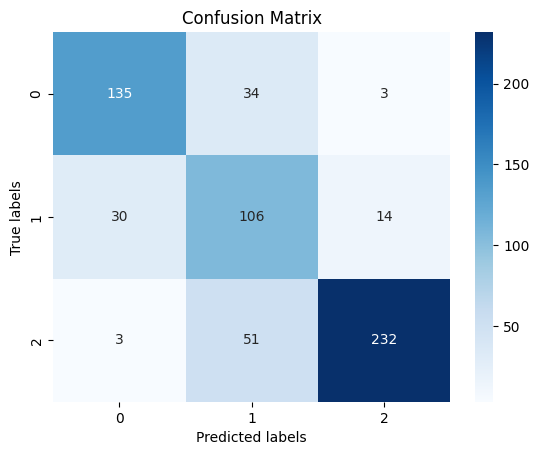

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       172
           1       0.55      0.71      0.62       150
           2       0.93      0.81      0.87       286

    accuracy                           0.78       608
   macro avg       0.76      0.77      0.76       608
weighted avg       0.80      0.78      0.79       608



In [394]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_Bst)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, y_pred_test_Bst))


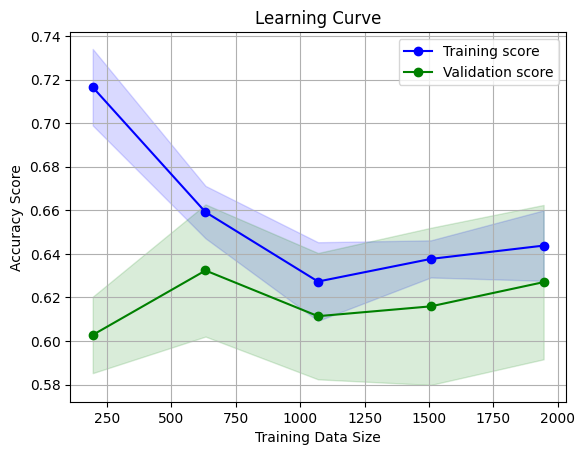

In [395]:

plot_learning_curves(pipeline_SVM_boosting, X_train, y_train, cv=cv)


## Stacking

In [396]:

logreg = LogisticRegression(max_iter=1000)

In [77]:


# Define base learners
base_learners = [
    ('svc', SVC(probability=True)),
    ('rf', RandomForestClassifier()),
    ('dt', DecisionTreeClassifier())
]


# Build the stacking classifier
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=logreg, cv=5)



In [78]:
pipeline_stacking = ImblearnPipeline([('preprocessor', preprocessor),
                                      ('smote', smote),
                           ('stacking', stacking_clf)])

In [79]:
param_grid_stack = {
    'stacking__svc__C': [0.1, 1, 10],
    'stacking__rf__n_estimators': [10, 50, 100],
    'stacking__rf__max_depth': [None, 10, 20],
    'stacking__final_estimator__C': [0.1, 1, 10]
}

In [80]:
grid_search_stacking = GridSearchCV(pipeline_stacking, param_grid_stack, cv=5, scoring='accuracy', verbose=1)
grid_search_stacking.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('to_float32',
                                                                                          Float32Transformer())]),
                                                                         ['avg_home_player_rating',
                                                                          'avg_away_player_rating',
                                                                          'home_buildUpPlaySpeed',
                                                                          'away_buildUpPlaySpeed',
                                                                          'home_defenceAggression',...
                                                           estimators=[('svc',
                                                                        SVC(probability=True)),
                                                                       ('rf',
                                                                        RandomForestClassifier()),
                                                                       ('dt',
                                                                        DecisionTreeClassifier())],
                                                           final_estimator=LogisticRegression(max_iter=1000)))]),
             param_grid={'stacking__final_estimator__C': [0.1, 1, 10],
                         'stacking__rf__max_depth': [None, 10, 20],
                         'stacking__rf__n_estimators': [10, 50, 100],
                         'stacking__svc__C': [0.1, 1, 10]},
             scoring='accuracy', verbose=1)

In [81]:
print("Best parameters:", grid_search_stacking.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search_stacking.best_score_))

# Evaluate on the test set
test_score = grid_search_stacking.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))


Best parameters: {'stacking__final_estimator__C': 0.1, 'stacking__rf__max_depth': None, 'stacking__rf__n_estimators': 10, 'stacking__svc__C': 1}
Best cross-validation accuracy: 0.86
Test set score: 0.88


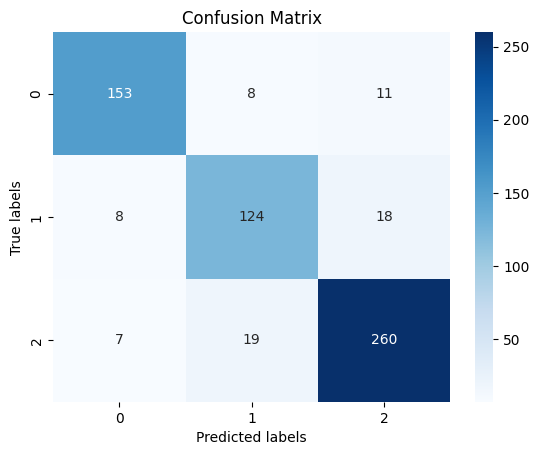

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       172
           1       0.82      0.83      0.82       150
           2       0.90      0.91      0.90       286

    accuracy                           0.88       608
   macro avg       0.88      0.88      0.88       608
weighted avg       0.88      0.88      0.88       608



In [82]:


# Predict on the validation set
y_pred_test_stack = grid_search_stacking.predict(X_test)

# Generating the confusion matrix
cm = confusion_matrix(y_test, y_pred_test_stack)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Printing the classification report
print(classification_report(y_test, y_pred_test_stack))

## Neural Networks

In [438]:
# `y_train` initially contains integers from 0 to 2
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [439]:
# Apply transformations
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [440]:
# determine the number of input features
n_features = X_train_preprocessed.shape[1]
n_features

86

In [441]:

# define model
model = Sequential()
model.add(Dense(5, activation='relu',  kernel_initializer='he_normal', kernel_regularizer=l2(0.01), input_shape=(n_features,)))
model.add(Dense(86,activation='relu',  kernel_initializer='he_normal', kernel_regularizer=l2(0.01)))
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# fit the model
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_171 (Dense)               │ (None, 5)              │           435 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_172 (Dense)               │ (None, 86)             │           516 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_173 (Dense)               │ (None, 3)              │           261 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,212 (4.73 KB)

 Trainable params: 1,212 (4.73 KB)

 Non-trainable params: 0 (0.00 B)

In [442]:
history = model.fit(X_train_preprocessed, y_train, validation_split=0.2, epochs=100, batch_size=32)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4446 - loss: 2.8567 - val_accuracy: 0.4353 - val_loss: 2.6006
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4746 - loss: 2.5323 - val_accuracy: 0.4969 - val_loss: 2.3014
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5388 - loss: 2.2493 - val_accuracy: 0.5893 - val_loss: 2.0037
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6086 - loss: 1.9687 - val_accuracy: 0.6612 - val_loss: 1.7295
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6788 - loss: 1.6771 - val_accuracy: 0.7228 - val_loss: 1.4889
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7461 - loss: 1.4395 - val_accuracy: 0.7618 - val_loss: 1.3019
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7795 - loss: 1.2482 - val_accuracy: 0.8111 - val_loss: 1.1541
Epoch 8/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8233 - loss: 1.1036 - val_accuracy: 0.8090 - v

In [443]:
# evaluate the model
loss, acc = model.evaluate(X_test_preprocessed, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.877


In [444]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

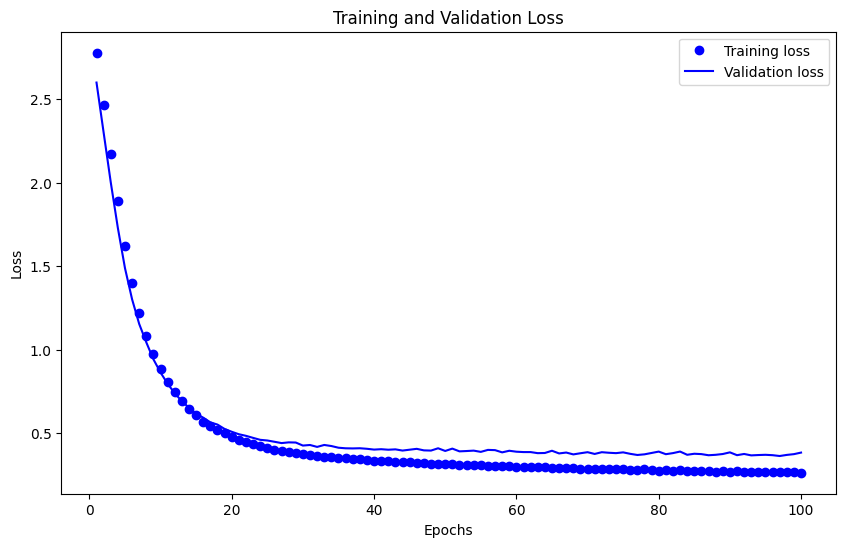

In [445]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives us blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives us a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [448]:
predictions_nn = model.predict(X_test_preprocessed)
predictions_nn = np.argmax(predictions_nn, axis=1)
y_test_class = np.argmax(y_test, axis=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [451]:
print(classification_report(y_test_class, predictions_nn, target_names=['Class 1', 'Class 2', 'Class 3']))

              precision    recall  f1-score   support

     Class 1       0.94      0.87      0.90       172
     Class 2       0.86      0.76      0.81       150
     Class 3       0.85      0.94      0.90       286

    accuracy                           0.88       608
   macro avg       0.88      0.86      0.87       608
weighted avg       0.88      0.88      0.88       608



## Results

In [455]:
model_metrics = {
    'Random Forest': {'accuracy': 0.86, 'precision_macro': 0.85, 'recall_macro': 0.84, 'f1_macro': 0.84, 'precision_weighted': 0.86, 'recall_weighted': 0.86, 'f1_weighted': 0.86},
    'SVM': {'accuracy': 0.82, 'precision_macro': 0.82, 'recall_macro': 0.83, 'f1_macro': 0.82, 'precision_weighted': 0.86, 'recall_weighted': 0.82, 'f1_weighted': 0.83},
    'Neural Network': {'accuracy': 0.88, 'precision_macro': 0.88, 'recall_macro': 0.86, 'f1_macro': 0.87, 'precision_weighted': 0.88, 'recall_weighted': 0.88, 'f1_weighted': 0.88},
    'Bagging with Random Forest': {'accuracy': 0.86, 'precision_macro': 0.85, 'recall_macro': 0.86, 'f1_macro': 0.85, 'precision_weighted': 0.87, 'recall_weighted': 0.86, 'f1_weighted': 0.86},
    'Gradient Boosting': {'accuracy': 0.87, 'precision_macro': 0.85, 'recall_macro': 0.85, 'f1_macro': 0.85, 'precision_weighted': 0.87, 'recall_weighted': 0.87, 'f1_weighted': 0.87},
    'Bagging with SVM': {'accuracy': 0.82, 'precision_macro': 0.83, 'recall_macro': 0.83, 'f1_macro': 0.82, 'precision_weighted': 0.87, 'recall_weighted': 0.82, 'f1_weighted': 0.83},
    'AdaBoost': {'accuracy': 0.78, 'precision_macro': 0.76, 'recall_macro': 0.77, 'f1_macro': 0.76, 'precision_weighted': 0.80, 'recall_weighted': 0.78, 'f1_weighted': 0.79},
    'Stacking': {'accuracy': 0.88, 'precision_macro': 0.88, 'recall_macro': 0.88, 'f1_macro': 0.88, 'precision_weighted': 0.88, 'recall_weighted': 0.88, 'f1_weighted': 0.88}
} 

In [456]:
models_ = list(model_metrics.keys())
accuracies = [model_metrics[model_]['accuracy'] for model_ in models_]
precision_macros = [model_metrics[model_]['precision_macro'] for model_ in models_]
recall_macros = [model_metrics[model_]['recall_macro'] for model_ in models_]
f1_macros = [model_metrics[model_]['f1_macro'] for model_ in models_]
precision_weighteds = [model_metrics[model_]['precision_weighted'] for model_ in models_]
recall_weighteds = [model_metrics[model_]['recall_weighted'] for model_ in models_]
f1_weighteds = [model_metrics[model_]['f1_weighted'] for model_ in models_]

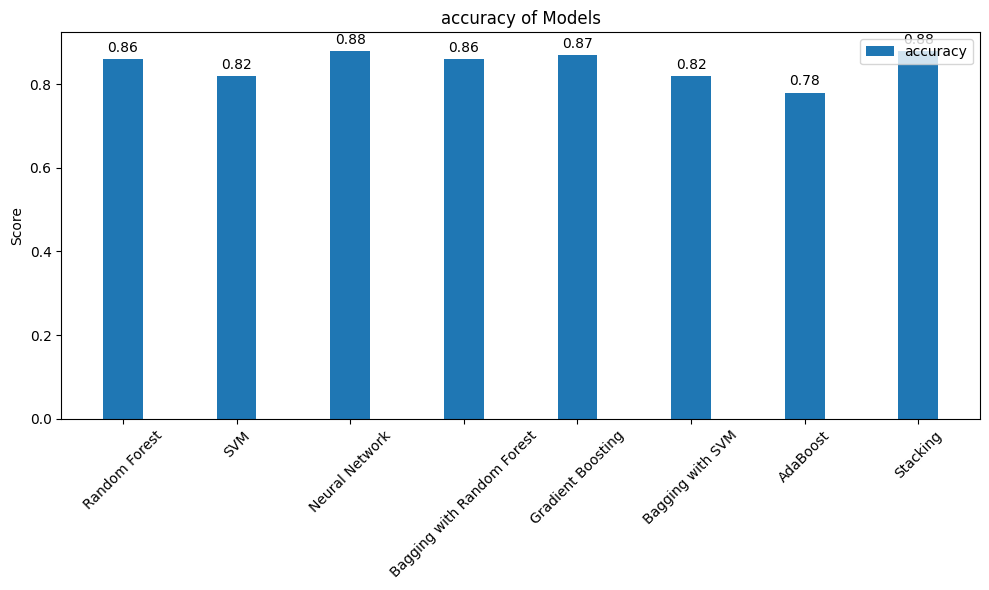

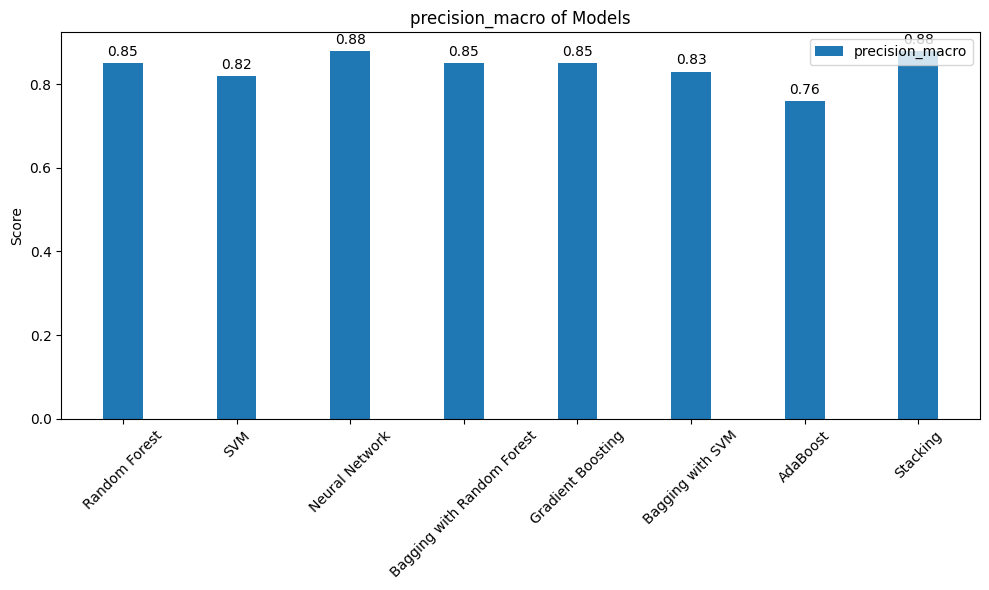

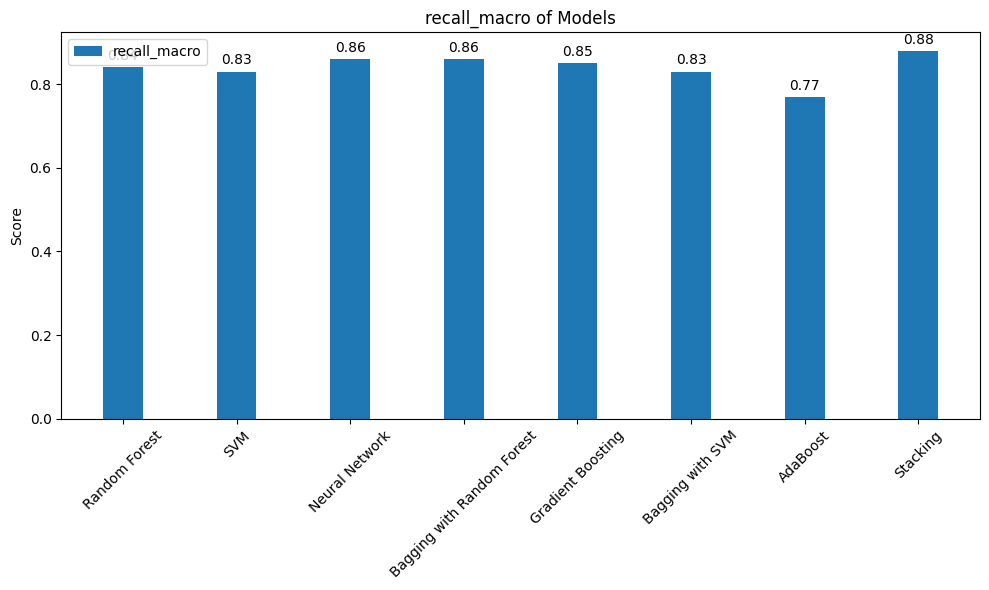

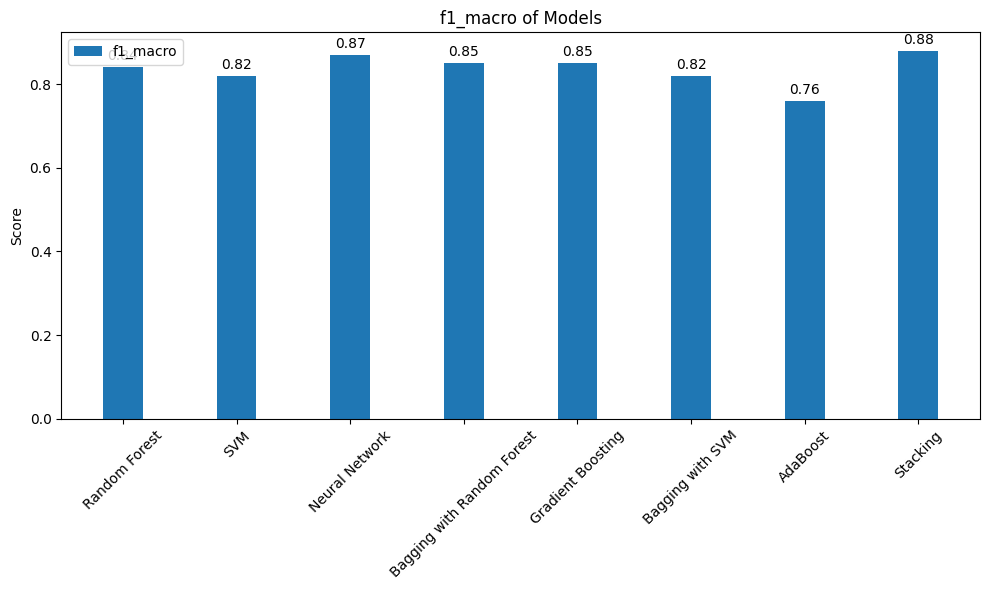

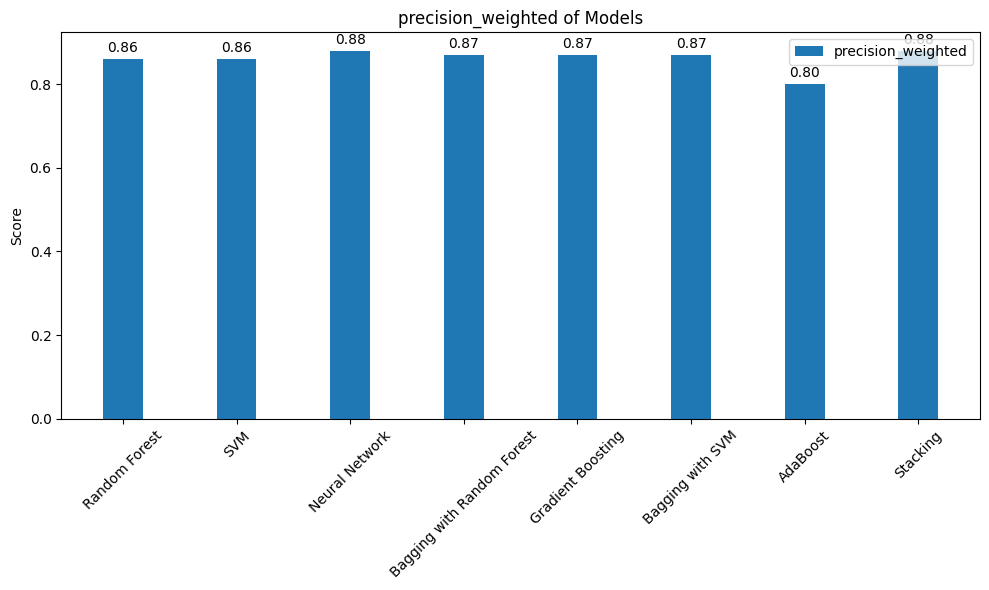

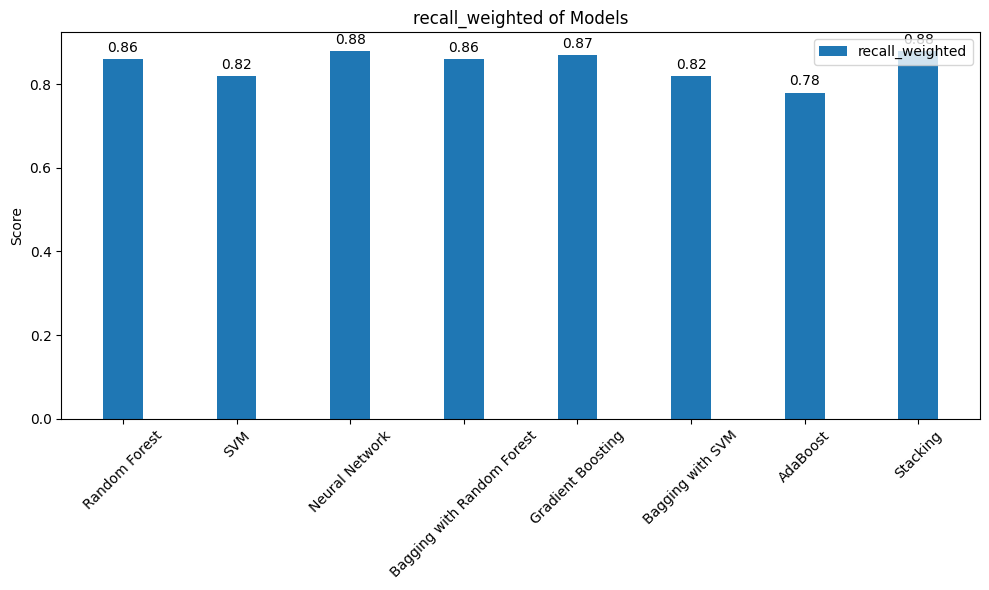

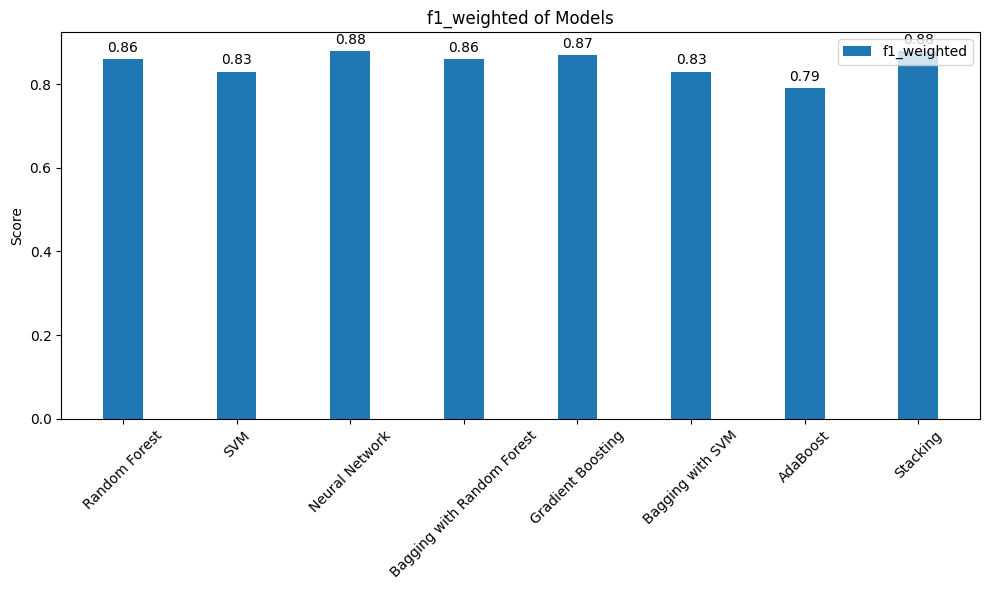

In [457]:

models_ = list(model_metrics.keys())
metrics = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'precision_weighted', 'recall_weighted', 'f1_weighted']
data = {metric: [model_metrics[model_][metric] for model_ in models_] for metric in metrics}

x = np.arange(len(models_))  # the label locations
width = 0.35  # the width of the bars

# Loop through each metric and create an individual plot
for metric, values in data.items():
    plt.figure(figsize=(10, 6))  # set the size of the figure
    rects = plt.bar(x, values, width, label=metric)
    plt.ylabel('Score')
    plt.title(f'{metric} of Models')
    plt.xticks(x, models_, rotation=45)
    plt.legend()

    # Attach a text label above each bar in rects, displaying its height
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


## Conclusion

This code demonstrated the use of machine learning techniques to predict football match outcomes based on team attributes, average player ratings, historical win rates, and goal statistics from recent matches. Among the models tested, the Stacking classifier and the Neural Network were the most effective, achieving high accuracy and robustness in prediction. Simpler models like Random Forest and Gradient Boosting also performed better, suggesting a trade-off between model complexity and interpretability. Future work could explore getting more data sources such as player-level data, match conditions to enhance the predictive power of the models. However, while this predictive modelling presents a power tool for forecasting football match outcomes, it requires careful implementation, continuous refinement and a balanced consideration of risk and reward to support decision making in the dynamic field of sports.